# k-vecinos más cercanos versión 2

In [1]:
import os
import path
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, precision_score, classification_report, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Path = "/home/michell21/Datasets/" #Puede cambiar de acuerdo al usuario

Instalar las siguientes librerías para leer el archivo

- conda install xlrd
- conda install openpyxl

In [3]:
read = pd.read_excel(Path+'Pozos_Michoacan.xlsx')

In [4]:
pozos = pd.DataFrame(pd.read_excel(Path+'Pozos_Michoacan.xlsx'))

In [5]:
pozos.head()

,#,Título,Latitud,Longitud,Estado,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
0,1,837156,"19°58'36.0006""","-101°16'41.0007""",MICHOACÁN DE OCAMPO,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,22800.0,AGRICOLA
1,2,836988,"19°59'22.0004""","-101°16'30.0003""",MICHOACÁN DE OCAMPO,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,9000.0,AGRICOLA
2,3,836992,"20°02'22.0006""","-101°09'00.0005""",MICHOACÁN DE OCAMPO,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,20020.0,AGRICOLA
3,4,836822,"20°01'50.0005""","-101°09'38.0006""",MICHOACÁN DE OCAMPO,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,6000.0,AGRICOLA
4,5,835739,"19°49'11.0005""","-101°08'37.0006""",MICHOACÁN DE OCAMPO,TARÍMBARO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,30000.0,SERVICIOS


In [28]:
pozos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   #                   1363 non-null   int64  
 1   Título              1363 non-null   object 
 2   Latitud             1363 non-null   object 
 3   Longitud            1363 non-null   object 
 4   Estado              1363 non-null   object 
 5   Municipio           1363 non-null   object 
 6   RegiónHidrológica   1363 non-null   object 
 7   Cuenca              1363 non-null   int64  
 8   AcuíferoHomologado  1363 non-null   object 
 9   Volumen (m3/año)    1363 non-null   float64
 10  Uso                 1363 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 117.3+ KB


In [5]:
pozos.describe()

,#,Cuenca,Volumen (m3/año)
count,1363.00000,1363.000000,1.363000e+03
mean,682.00000,28.546588,1.558366e+05
std,393.60852,67.485278,3.884465e+05
min,1.00000,0.000000,0.000000e+00
25%,341.50000,0.000000,1.500000e+04
50%,682.00000,0.000000,4.668000e+04
75%,1022.50000,0.000000,1.621800e+05
max,1363.00000,188.000000,1.103760e+07


Como no hay registros vacios, se procede a trabajar con los datos. Lo primero será borrar la columna # 

# Visualización de Datos

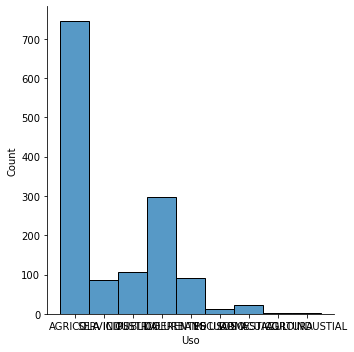

In [6]:
sns.displot(pozos['Uso'], palette="rocket")

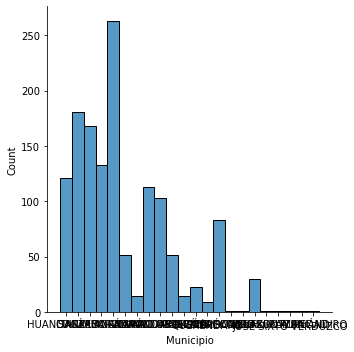

In [7]:
sns.displot(pozos['Municipio'], palette="rocket")

In [5]:
pozos.drop(['#', 'Estado', "Título"], axis = 1, inplace = True) #Eliminamos estos dos ya que no aportan información

In [6]:
def grad2float(datos, id1,id2):
    characters = '°\'"'
    lista = []
    for i in datos:
        i = ''.join( x for x in i if x not in characters)
        if i[0] == '-':
            a = -1*(3600*float(i[1:id1]) + 60*float(i[id1:id2]) + float(i[id2:])) #Para longitud
        else:
            a = 3600*float(i[:id1]) + 60*float(i[id1:id2]) + float(i[id2:])
        #a = 3600*float(i[:4]) + 60*float(i[4:6]) + float(i[6:]) #Para latitud
        lista.append(float(a))
    return lista

In [7]:
pozos['Latitud'] = grad2float(pozos['Latitud'], 2, 4)
pozos['Longitud'] = grad2float(pozos['Longitud'], 4, 6)

In [8]:
pozos['Uso'].value_counts()  #No unir a Diferentes usos

AGRICOLA           745
PUBLICO URBANO     296
INDUSTRIAL         107
DIFERENTES USOS     91
SERVICIOS           87
DOMESTICO           23
PECUARIO            11
ACUACULTURA          2
AGROINDUSTIAL        1
Name: Uso, dtype: int64

In [9]:
pozos['AcuíferoHomologado'].value_counts()  #Eliminar

1602  - MORELIA-QUERENDARO      1138
1602 - MORELIA-QUERENDARO        197
1610 - CIUDAD HIDALGO-TUXPAN      28
Name: AcuíferoHomologado, dtype: int64

In [9]:
pozos[pozos['Uso'] == 'ACUACULTURA']

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
280,71665.0,-363020.0,ZINAPÉCUARO,LERMA-SANTIAGO,0,1602 - MORELIA-QUERENDARO,30000.0,ACUACULTURA
1302,71663.0,-364157.0,CUITZEO,LERMA-SANTIAGO,0,1602 - MORELIA-QUERENDARO,15000.0,ACUACULTURA


In [10]:
pozos[pozos['Uso'] == 'AGROINDUSTIAL']

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
941,72255.0,-364034.0,SANTA ANA MAYA,LERMA-SANTIAGO,0,1602 - MORELIA-QUERENDARO,40000.0,AGROINDUSTIAL


In [8]:
#Reemplazar 1602  - MORELIA-QUERENDARO con 1602 - MORELIA-QUERENDARO
pozos['AcuíferoHomologado'].replace('1602  - MORELIA-QUERENDARO', '1602 - MORELIA-QUERENDARO', inplace = True)

In [9]:
pozos.describe()

,Latitud,Longitud,Cuenca,Volumen (m3/año)
count,1363.000000,1363.000000,1363.000000,1.363000e+03
mean,71490.946855,-364096.132121,28.546588,1.558366e+05
std,645.397221,721.149748,67.485278,3.884465e+05
min,68005.000000,-371361.000000,0.000000,0.000000e+00
25%,71118.004800,-364411.500000,0.000000,1.500000e+04
50%,71468.000000,-364145.000000,0.000000,4.668000e+04
75%,71938.250000,-363778.000000,0.000000,1.621800e+05
max,79260.000000,-362170.000000,188.000000,1.103760e+07


In [10]:
pozos.head()

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
0,71916.0006,-364601.0007,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,22800.0,AGRICOLA
1,71962.0004,-364590.0003,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,9000.0,AGRICOLA
2,72142.0006,-364140.0005,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,20020.0,AGRICOLA
3,72110.0005,-364178.0006,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,6000.0,AGRICOLA
4,71351.0005,-364117.0006,TARÍMBARO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,30000.0,SERVICIOS


# Dividir los datos en $X$ y $y$

In [9]:
X = pozos.iloc[:,:-1]
y = pozos['Uso']
#y = pozos[['Uso', 'Uso Ponderado']]

In [12]:
X.head()

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año)
0,71916.0006,-364601.0007,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,22800.0
1,71962.0004,-364590.0003,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,9000.0
2,72142.0006,-364140.0005,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,20020.0
3,72110.0005,-364178.0006,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,6000.0
4,71351.0005,-364117.0006,TARÍMBARO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,30000.0


In [13]:
y.head() 

0     AGRICOLA
1     AGRICOLA
2     AGRICOLA
3     AGRICOLA
4    SERVICIOS
Name: Uso, dtype: object

## Codificar los datos categoricos y Escalar los datos numericos en X

In [10]:
def codificar(data):
    cat = []
    num = []
    for i in data.columns:
        if data[i].dtypes == 'object':
            cat.append(i)
        elif data[i].dtypes == 'float64' or 'int64':
            num.append(i)
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(data[num])
    data[num] = scaled_values
    code = LabelEncoder()
    data[cat] = data[cat].apply(code.fit_transform)
    print('num', num)
    print('cat',cat)
    return data

In [11]:
x_cod = X.copy()
X_cod = codificar(X)

num ['Latitud', 'Longitud', 'Cuenca', 'Volumen (m3/año)']
cat ['Municipio', 'RegiónHidrológica', 'AcuíferoHomologado']


In [12]:
X_cod.head()

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año)
0,0.347490,0.735502,7,1,1.0,0,0.002066
1,0.351577,0.736699,7,1,1.0,0,0.000815
2,0.367570,0.785660,5,1,1.0,0,0.001814
3,0.364727,0.781525,5,1,1.0,0,0.000544
4,0.297290,0.788162,18,1,1.0,0,0.002718


# Dividir los datos en Train y Test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_cod, y, test_size = 0.3, shuffle=True)

# Construir modelo

In [14]:
#n_neighbors = 3

knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [15]:
# Predicción
def prediccion(model, X, y):
    pred = model.predict(X)
    y_pred = pd.Series(pred, index=y.index)
    print('Precisión = ', precision_score(y, y_pred, average='micro'))
    print(classification_report(y, pred))
    plot_confusion_matrix(model, X, y)
    return y_pred

Precisión =  0.6332518337408313
                 precision    recall  f1-score   support

    ACUACULTURA       0.00      0.00      0.00         1
       AGRICOLA       0.76      0.78      0.77       226
DIFERENTES USOS       0.14      0.20      0.17        20
      DOMESTICO       0.20      0.17      0.18         6
     INDUSTRIAL       0.79      0.77      0.78        43
       PECUARIO       0.00      0.00      0.00         4
 PUBLICO URBANO       0.53      0.42      0.47        86
      SERVICIOS       0.26      0.35      0.30        23

       accuracy                           0.63       409
      macro avg       0.33      0.34      0.33       409
   weighted avg       0.64      0.63      0.63       409



/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

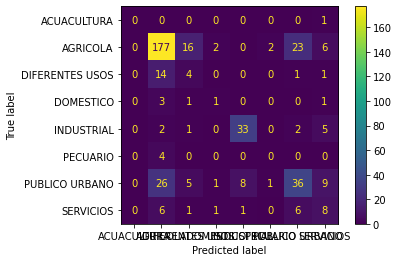

In [16]:
y_pred = prediccion(knn, X_test, y_test)

## Saber cuales fueron las etiquetas que sí acertó

In [17]:
def match(y_t, y_p):
    matched = {}
    aux = 0
    for i, j in zip(y_t, y_p):
        if i == j:
            matched[y_t.index[aux]]= i
        aux+=1
    return matched
aux = match(y_test, y_pred)

In [18]:
len(aux)

266

## Obtener el volumen total

In [18]:
volumen_total = sum(pozos['Volumen (m3/año)'].values)
print(volumen_total)

212405314.46999994


In [19]:
def volumen(data, indices, vol):
    vol_pond = {}
    for i in list(indices.keys()):
        v_pond = (data.iloc[i][6])/vol
        #print()
        vol_pond[i] = indices[i], v_pond
    vol_pond = pd.DataFrame([[key, vol_pond[key][0], vol_pond[key][1]] for key in vol_pond.keys()], columns=['ID', 'Uso', 'Volumen Ponderado'])
    return vol_pond
volumen_pon = volumen(pozos, aux, volumen_total)

In [20]:
volumen_pon.groupby('Uso').sum()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,127330,0.103895
DIFERENTES USOS,3181,0.000815
DOMESTICO,1221,0.000668
INDUSTRIAL,19849,0.083953
PUBLICO URBANO,26740,0.027119
SERVICIOS,2728,0.001771


In [21]:
volumen_pon['Volumen Ponderado'].sum()

0.21822134222798203

Si consideraos el volumen que el modelo sí acertó, tenemos un 21% 

## Obtener el volumen ponderado por etiquetas

In [22]:
v = pozos.groupby('Uso').sum()
v = v['Volumen (m3/año)']
v

Uso
ACUACULTURA           45000.00
AGRICOLA           91725771.79
AGROINDUSTIAL         40000.00
DIFERENTES USOS     5866832.32
DOMESTICO           1354190.77
INDUSTRIAL         60461754.00
PECUARIO             195005.00
PUBLICO URBANO     47014568.69
SERVICIOS           5702191.90
Name: Volumen (m3/año), dtype: float64

In [23]:
def vol_lab(data, indices, vol):
    vol_pond = {}
    for i in list(indices.keys()):
        vl = vol[indices[i]] #volumen total por etiqueta
        v_pond = (data.iloc[i])/vl #Volumen ponderado por etiqueta
        vol_pond[i] = indices[i], v_pond
    vol_pond = pd.DataFrame([[key, vol_pond[key][0], vol_pond[key][1]] for key in vol_pond.keys()], columns=['ID', 'Uso', 'Volumen Ponderado'])
    return vol_pond
vol_label = vol_lab(pozos['Volumen (m3/año)'], aux, v)

In [24]:
vol_label.groupby('Uso').sum()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,127330,0.240584
DIFERENTES USOS,3181,0.029509
DOMESTICO,1221,0.104795
INDUSTRIAL,19849,0.294933
PUBLICO URBANO,26740,0.122520
SERVICIOS,2728,0.065969


In [25]:
vol_label['Volumen Ponderado'].sum()

0.8583093573280843

Como se puede ver en esta segunda tabla, hay mejores resultados si ponderamos por etiqueta

# Hacer el mismo procedimiento con los siguientes modelos

## Hacer un nuevo modelo con cross validation

In [26]:
knn_cv = KNeighborsClassifier()
cv_scores = cross_val_score(knn_cv, X_cod, y, cv=10)
print(cv_scores)
print("Score promedio", np.mean(cv_scores))

/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


[0.70072993 0.5620438  0.60583942 0.64705882 0.71323529 0.64705882
 0.67647059 0.66911765 0.63970588 0.52205882]
Score promedio 0.6383319021039073


El mejor score es con k = 5

In [27]:
knn5 = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn5.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

Precisión =  0.6479217603911981
                 precision    recall  f1-score   support

    ACUACULTURA       0.00      0.00      0.00         1
       AGRICOLA       0.76      0.82      0.79       226
DIFERENTES USOS       0.16      0.15      0.15        20
      DOMESTICO       0.25      0.17      0.20         6
     INDUSTRIAL       0.80      0.77      0.79        43
       PECUARIO       0.00      0.00      0.00         4
 PUBLICO URBANO       0.53      0.42      0.47        86
      SERVICIOS       0.24      0.30      0.27        23

       accuracy                           0.65       409
      macro avg       0.34      0.33      0.33       409
   weighted avg       0.64      0.65      0.64       409



/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

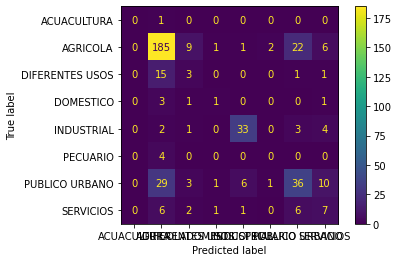

In [28]:
y_pred5 = prediccion(knn5, X_test, y_test)

In [29]:
#Obtener las etiquetas acertadas
auxk5 = match(y_test, y_pred5)
len(auxk5) #por ahora hay +10 etiquetas que en el caso anterior

265

In [30]:
vol_labelk5 = vol_lab(pozos['Volumen (m3/año)'], auxk5, v)
vol_labelk5.groupby('Uso').sum()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,131908,0.245123
DIFERENTES USOS,2954,0.047044
DOMESTICO,1221,0.104795
INDUSTRIAL,20627,0.293822
PUBLICO URBANO,27568,0.126850
SERVICIOS,2540,0.053342


In [31]:
vol_labelk5['Volumen Ponderado'].sum()

0.870976097181275

En este caso, hay un mejor resultado en comparación al modelo anterior

## Usar GridSearchCV para ver el número óptimo de K

In [32]:
#create new a knn model
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=10)
knn_gscv.fit(X_train, y_train)

/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [33]:
knn_gscv.best_params_

{'n_neighbors': 4}

In [34]:
knn_gscv.best_score_

0.675109649122807

Precisión =  0.6479217603911981
                 precision    recall  f1-score   support

    ACUACULTURA       0.00      0.00      0.00         1
       AGRICOLA       0.72      0.86      0.79       226
DIFERENTES USOS       0.17      0.10      0.12        20
      DOMESTICO       0.50      0.17      0.25         6
     INDUSTRIAL       0.72      0.79      0.76        43
       PECUARIO       0.00      0.00      0.00         4
 PUBLICO URBANO       0.49      0.37      0.42        86
      SERVICIOS       0.09      0.04      0.06        23

       accuracy                           0.65       409
      macro avg       0.34      0.29      0.30       409
   weighted avg       0.60      0.65      0.62       409



/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

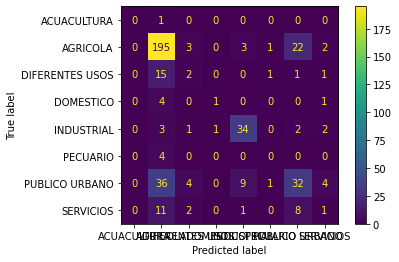

In [35]:
knn_grid = knn_gscv.best_estimator_
y_pred_grid = prediccion(knn_grid, X_test, y_test)

In [37]:
#Obtener las etiquetas acertadas
aux_grid = match(y_test, y_pred_grid)
len(aux_grid) #por ahora hay +10 etiquetas que en el caso anterior

265

In [38]:
#Sacar el volumen ponderado por etiquetas
vol_label_grid = vol_lab(pozos['Volumen (m3/año)'], aux_grid, v)
vol_label_grid.groupby('Uso').sum()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,139710,0.263035
DIFERENTES USOS,1949,0.030681
DOMESTICO,1221,0.104795
INDUSTRIAL,21520,0.294076
PUBLICO URBANO,25637,0.103706
SERVICIOS,158,0.006788


In [40]:
vol_label_grid['Volumen Ponderado'].sum()

0.8030799704940065

Por ahora, el segundo método ha funcionado mejor

# Encontrar el valor de k

([<matplotlib.axis.YTick at 0x7f8d2aad2cd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

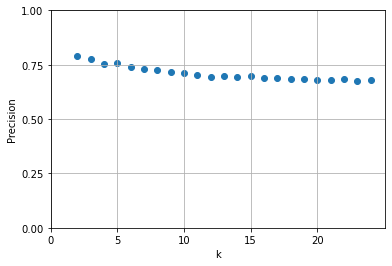

In [41]:
#No usar test. Se sobreajusta

k_range = range(2, 25)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    pred1=knn.predict(X_train)
    scores.append(precision_score(y_train, pred1, average='micro'))
#plt.figure()
plt.scatter(k_range, scores)
plt.xlabel('k')
plt.ylabel('Precision')
plt.grid()
plt.xticks([0,5,10,15,20])
plt.yticks([0, 0.25, 0.5, 0.75, 1])

A patir de k = 15, la precisión empieza a ocilar 

In [42]:
knn_k = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_k.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15, weights='distance')

Precisión =  0.6797066014669927
                 precision    recall  f1-score   support

    ACUACULTURA       0.00      0.00      0.00         1
       AGRICOLA       0.74      0.88      0.81       226
DIFERENTES USOS       0.00      0.00      0.00        20
      DOMESTICO       0.50      0.17      0.25         6
     INDUSTRIAL       0.86      0.74      0.80        43
       PECUARIO       0.00      0.00      0.00         4
 PUBLICO URBANO       0.56      0.47      0.51        86
      SERVICIOS       0.23      0.26      0.24        23

       accuracy                           0.68       409
      macro avg       0.36      0.31      0.33       409
   weighted avg       0.64      0.68      0.65       409



/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

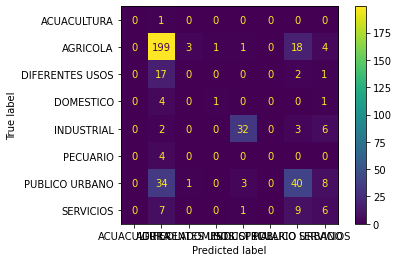

In [44]:
y_pred_k = prediccion(knn_k, X_test, y_test)

In [45]:
auxk = match(y_test, y_pred_k)
len(auxk) #por ahora hay -1 etiquetas que en el caso anterior

278

In [46]:
#Sacar el volumen ponderado por etiquetas
vol_labelk = vol_lab(pozos['Volumen (m3/año)'], auxk, v)
vol_labelk.groupby('Uso').sum()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,142787,0.253202
DOMESTICO,1221,0.104795
INDUSTRIAL,19654,0.293775
PUBLICO URBANO,29630,0.138795
SERVICIOS,2765,0.036870


In [47]:
vol_labelk['Volumen Ponderado'].sum()

0.8274368861640276

El modelo creado con valdación cruzada nos da mejores resultados con 87% de los pozos identificados correctamente de acuerdo a sus etiquetas

## Graficar los datos

In [48]:
pozos['Uso'].unique()

array(['AGRICOLA', 'SERVICIOS', 'INDUSTRIAL', 'PUBLICO URBANO',
       'DIFERENTES USOS', 'PECUARIO', 'DOMESTICO', 'ACUACULTURA',
       'AGROINDUSTIAL'], dtype=object)

In [63]:
def grafica(data):
    labels = data.map({'AGRICOLA': 0, 'SERVICIOS': 1, 'INDUSTRIAL': 2, 'PUBLICO URBANO': 3,
                   'DIFERENTES USOS': 4, 'PECUARIO':5, 'DOMESTICO': 6, 'ACUACULTURA': 7, 'AGROINDUSTIAL': 8},na_action=None)
    for i in range(10):
        plt.scatter(x=labels[labels==i].index, y=labels[labels==i], cmap='Sequential')
    return plt.show()

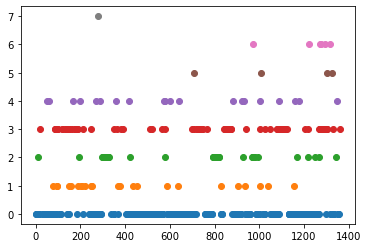

In [64]:
grafica(y_test) #original

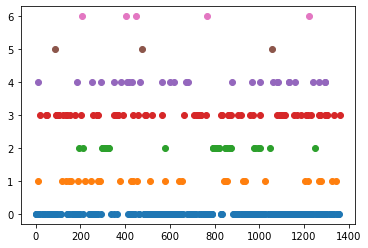

In [65]:
grafica(y_pred) #primera prediccion

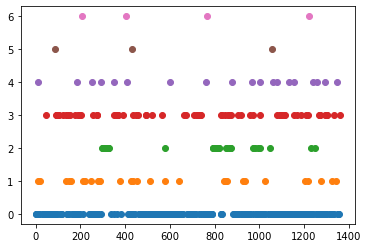

In [66]:
grafica(y_pred5) #cv=5

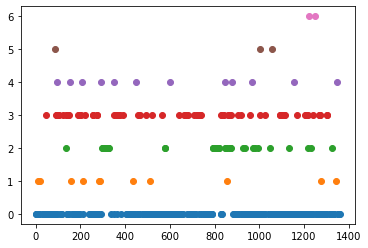

In [67]:
grafica(y_pred_grid) #Grid

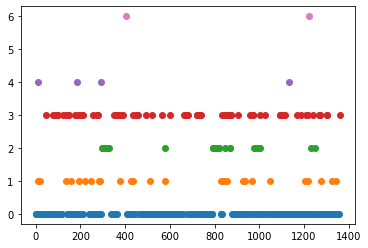

In [68]:
grafica(y_pred_k)